# Green tea compounds in plasma

- using a QIIME2 2021.11 conda environment

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import seaborn as sns

from qiime2 import Artifact, Visualization

from skbio.diversity import beta_diversity, alpha_diversity
from skbio.diversity.beta import unweighted_unifrac
from skbio.stats import distance, ordination
from skbio import DistanceMatrix

from sklearn.decomposition import PCA

from scipy.spatial import procrustes
from scipy.stats import ttest_ind, pearsonr, f_oneway, t, sem

import pickle

from pathlib import Path
import subprocess

%matplotlib inline

## Read in data

### Metadata

In [65]:
metadata = pd.read_csv("../metadata/mapping.tsv", sep="\t")
metadata.head()

,#SampleID,MetaboSampleID,Plate,Well,#,BarcodeSequence,LinkerPrimerSequence,BarcodeName,PID,Group,Study,DNA_Conc,Amplified_Conc,Extraction_Date,Extraction_Location,Extraction_By
0,GT.063_N,18,2,B07,48,TTAACAAGGCAA,GTGYCAGCMGCCGCGGTAA,515rcbc222,63,Red,Green Tea,15.3,62.55,10/13/21,BSC,MK
1,GT.063_R,3,1,E01,49,TGATGTGCTAAG,GTGYCAGCMGCCGCGGTAA,515rcbc48,63,Red,Green Tea,39.9,51.15,10/13/21,BSC,MK
2,GT.066_B,17,2,A09,54,CCAGGACAGGAA,GTGYCAGCMGCCGCGGTAA,515rcbc200,66,Red,Green Tea,18.6,67.90,10/13/21,BSC,MK
3,GT.066_N,29,1,F12,55,AACTCAATAGCG,GTGYCAGCMGCCGCGGTAA,515rcbc167,66,Red,Green Tea,32.9,41.80,10/13/21,BSC,MK
4,GT.074_N,2,2,C12,52,GATATACCAGTG,GTGYCAGCMGCCGCGGTAA,515rcbc227,74,Red,Green Tea,9.8,38.75,10/13/21,BSC,MK


In [66]:
metabo_metadata = metadata.set_index("MetaboSampleID").sort_index()

### Aqueous metabolome fraction

In [67]:
aqueous = pd.read_csv("../metabolome/Aqueous_compounds_NOT_found.tsv",
                      sep="\t", index_col="Compound").T
aqueous.drop(index=["Product Mass", "QualifierMass", "Retention Time"], inplace=True)
aqueous.head()

Compound,1-AMINOCYCLOPROPANE-1-CARBOXYLATE**_1.039,"1-Fluorocyclohexadiene-cis,cis-1,2-diol_2.279",2-(1-Ethoxy-2-hydroxy)propyl-4-methoxyphenol_7.363,"2,5-Furandicarboxylic acid_1.474","2,7-Dideacetyl-2,7-dibenzoyl-taxayunnanine F_9.347",3-Methylglutaconic acid_2.213,4-GUANIDINOBUTANOATE**_1.4,5'-Adenosine monophosphate_1.642,Acetylagmatine_2.216,Adenine_2.163,...,Threonine_1.025,Threoninyl-Proline_3.631,trans-Aconitic acid_1.49,Tryptophyl-Leucine_7.759,Tyrosyl-Threonine_5.809,Valganciclovir_8.169,Valyl-Hydroxyproline_1.651,Valyl-Tyrosine_6.482,Volemitol_6.34,Xanthurenic acid_7.166
report.results_GT_001_SBAQ_1(raw),40046.598,226173.31,21983.977,84726.74,1911.6484,22331.076,38775.168,3282301.8,19666.39,12398.171,...,155209.78,76959.445,0.00001,13797.909,41825.22,16451.324,294056.3,14520.984,0.00001,256461.94
report.results_GT_001_SBAQ_10(raw),53031.887,365835.56,19103.723,106907.586,0.00001,50230.883,25104.19,6591378.0,0.00001,38902.44,...,174718.86,411932.94,0.00001,30013.299,88791.39,7235.483,3583.94,8145.5244,0.00001,2417664.8
report.results_GT_001_SBAQ_11(raw),30424.518,130394.37,16473.295,151247.69,61599.125,38810.285,4443.2563,8235889.5,1466.4312,352891.06,...,124468.445,77777.01,0.00001,30760.3,61276.723,32782.79,7032.5864,1707.6627,35242.43,612863.4
report.results_GT_001_SBAQ_12(raw),72447.9,370484.47,17625.605,164855.05,0.00001,15570.925,37243.28,9681461.0,12532.127,396875.38,...,301709.72,65381.12,111066.51,26817.178,39467.59,7598.1157,18484.375,1070.6887,0.00001,482975.62
report.results_GT_001_SBAQ_13(raw),22527.541,730713.75,21223.133,0.00001,0.00001,26655.775,21207.67,4716256.0,0.00001,176904.56,...,85089.055,16655.945,0.00001,14800.214,28879.777,50207.086,222386.55,4386.807,0.00001,155058.25


In [68]:
raw_indexes =        [x for x in list(aqueous.index) if ("Log2(normalized)" not in x)]
normalized_indexes = [x for x in list(aqueous.index) if ("(raw)" not in x)]

raw_aqueous = aqueous.loc[raw_indexes]
log_aqueous = aqueous.loc[normalized_indexes]

In [69]:
raw_aqueous.index = [int(x.split("SBAQ_")[-1][:-5]) if ("SBAQ_" in x)
                     else x 
                     for x in list(raw_aqueous.index)]

log_aqueous.index = [int(x.split("SBAQ_")[-1][:-18]) if ("SBAQ_" in x)
                     else x 
                     for x in list(log_aqueous.index)]

### Metabolome lipid fraction

In [70]:
lipid = pd.read_csv("../metabolome/Lipid_compounds_NOT_found.tsv",
                      sep="\t", index_col="Compound").T
lipid.drop(index=["Product Mass", "QualifierMass", "Retention Time"], inplace=True)
lipid.head()

Compound,?-Hederin_1.738,16:3 Cholesteryl ester_7.312,2-(1-Ethoxy-2-hydroxy)propyl-4-methoxyphenol-2-methyl-butyrate_1.111,20-Deoxynarasin_4.939,22:3-Glc-Stigmasterol_7.436,"2alpha,5alpha,10beta-Triacetoxy-14beta-propionyloxytaxa-4(20),11-diene_1.622",2-Phenylethyl beta-D-glucopyranoside_0.54,"3,4,5-Trimethoxy cinnamic acid_0.672","3beta,16alpha,28-Trihydroxyolean-11,13(18)-dien-3beta-yl-beta-D-glucopyranosyl-(1--6)-beta-D-[alpha_5.381",3beta-Acetyl ursa-14-en-16-one_3.538,...,Thujyl 19-trachylobanoate_3.099,"Tirucall-7-en-3,24-dione_2.691","Tirucall-7-en-3,24-dione_2.98",Tocoretinate_7.741,Trospium_1.997,TXB2-d4_1.835,Vernoflexin_0.988,Violaxanthin_2.707,Vitetrifolin B_1.016,Wilforlide B_2.565
report.results_GT_001_Lipid_1(raw),56219.617,1087695.1,109131.9,103360.67,41924.105,9865363.0,119708.62,62592.668,33275.438,291444.1,...,22921.44,40028.992,149900.75,3120.228,40019.36,47572.23,11229.537,17523.312,20057.725,13755.35
report.results_GT_001_Lipid_10(raw),32061.193,1038337.0,63306.66,78818.6,119020.89,10100000.0,109575.63,184112.45,45062.16,389192.25,...,7018581.0,80330.51,44072.73,3118.1797,58863.594,20184.217,12627.028,35387.56,92812.86,23148.236
report.results_GT_001_Lipid_11(raw),29988.643,1054205.4,145057.73,76945.875,605769.75,9624171.0,126006.586,233595.83,46176.418,463414.97,...,26888.014,309321.47,309321.47,64606.19,39956.305,91749.02,30125.65,52756.51,71978.79,45386.92
report.results_GT_001_Lipid_12(raw),24094.19,1521625.5,154949.45,63655.99,242689.47,10100000.0,118021.32,44854.58,60092.71,628400.44,...,15838.838,45995.71,28603.066,4359.994,326787.5,448886.2,35982.9,15949.491,30764.615,202966.02
report.results_GT_001_Lipid_13(raw),13393.443,809276.06,146848.6,74719.8,565397.5,9646937.0,83725.75,125411.97,225879.1,455431.34,...,23281.047,37906.156,51721.24,41807.258,579167.44,4550.2153,17649.176,35438.66,55854.992,19817.611


In [71]:
raw_lipid_indexes =        [x for x in list(lipid.index) if ("Log2(normalized)" not in x)]
normalized_lipid_indexes = [x for x in list(lipid.index) if ("(raw)" not in x)]

raw_lipid = lipid.loc[raw_lipid_indexes]
log_lipid = lipid.loc[normalized_lipid_indexes]

In [72]:
raw_lipid.index = [int(x.split("Lipid_")[-1][:-5]) if ("Lipid_" in x)
                     else x 
                     for x in list(raw_lipid.index)]

log_lipid.index = [int(x.split("Lipid_")[-1][:-18]) if ("Lipid" in x)
                     else x 
                     for x in list(log_lipid.index)]

In [73]:
metabo_info_cols = ['Compound Name','Retention Time', 'Measured Retention Time', 
                    'Product Mass','QualifierMass', 'CASNumber', 
                    'CompoundType', 'ISTDCompoundName', 'Mass Column']

### Microbiome

In [74]:
microbiome = Artifact.load("../microbiome/tax_filtered_GT.qza").view(pd.DataFrame)

In [75]:
tax = Artifact.load("../microbiome/taxonomy_GT.qza").view(pd.DataFrame)
tax = tax.to_dict()["Taxon"]
microbiome.rename(columns=tax, inplace=True) # map OTUs to taxonomy name

In [76]:
microbiome_mat = np.matrix(microbiome)
microbiome_mat /= microbiome_mat.sum(axis=1) #convert to relative abundances

microbiome = pd.DataFrame(microbiome_mat, columns=microbiome.columns, index=microbiome.index)

In [77]:
microbiome_index_mapper = metadata.set_index("#SampleID")["MetaboSampleID"].to_dict()

new_microbiome_index = [int(microbiome_index_mapper[x]) for x in list(microbiome.index)]
microbiome.index = new_microbiome_index
microbiome = microbiome.sort_index()

### Reindex metadata

In [78]:
metadata = metadata.set_index("MetaboSampleID").sort_index()

In [79]:
#check that all index are same
sum(metadata.index == microbiome.index)/len(microbiome.index)

1.0

## Analysis

### Metabolome beta diversity

#### Function for ellipses

In [80]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

### PCA

In [81]:
aqueous_pca = PCA(n_components=3)
aqueous_pca_res = aqueous_pca.fit_transform(raw_aqueous.drop(metabo_info_cols, 
                                                             axis=0, errors="ignore").reindex(metabo_metadata.index))

In [82]:
GF = metabo_metadata["PID"].apply(lambda x: "Germ free" if x=="Control" else "Humanized")

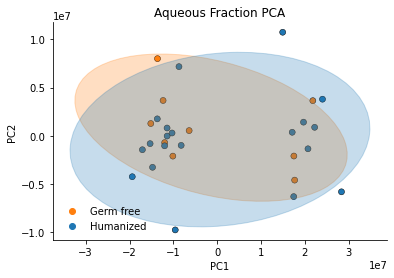

In [83]:
ax = sns.scatterplot(x=aqueous_pca_res[:,0], y=aqueous_pca_res[:,1],
                     hue=GF, hue_order=["Germ free", "Humanized"],
                     palette=["tab:orange","tab:blue"], edgecolor="black")
ax.set(xlabel="PC1", ylabel="PC2", title="Aqueous Fraction PCA")
ax.spines[["top", "right"]].set_visible(False)

confidence_ellipse(aqueous_pca_res[GF=="Germ free", 0], 
                   aqueous_pca_res[GF=="Germ free", 1], 
                   n_std=2.0,
                   ax=ax, edgecolor='tab:orange',
                   alpha=0.25, facecolor='tab:orange')

confidence_ellipse(aqueous_pca_res[GF=="Humanized", 0], 
                   aqueous_pca_res[GF=="Humanized", 1], 
                   n_std=2.0,
                   ax=ax, edgecolor='tab:blue',
                   alpha=0.25, facecolor='tab:blue')

plt.legend(title=None, frameon=False)

#for i, name in enumerate(metabo_metadata.index):
#    ax.text(x=aqueous_pca_res[i,0],
#            y=aqueous_pca_res[i,1],
#            s=name)

**To see if 12, 25, and 21** look a certain way with the microbiome...

In [84]:
Visualization.load("../microbiome/core-metrics/taxa-bar-GT.qzv")

<visualization: Visualization uuid: f572ae2a-0689-481d-aa0c-ae38dada7250>

In [85]:
metabo_metadata.loc[[12,25,21]]

,#SampleID,Plate,Well,#,BarcodeSequence,LinkerPrimerSequence,BarcodeName,PID,Group,Study,DNA_Conc,Amplified_Conc,Extraction_Date,Extraction_Location,Extraction_By
MetaboSampleID,,,,,,,,,,,,,,,
12,GT.GFR_CO,2,C06,59,TGGTGGAGTTTC,GTGYCAGCMGCCGCGGTAA,515rcbc221,Control,Orange,Green Tea,12.3,54.7,10/13/21,BSC,MK
25,GT.GFB_C.R,2,F03,47,CACCCTTGCGAC,GTGYCAGCMGCCGCGGTAA,515rcbc254,Control,Red,Green Tea,6.0,76.0,10/13/21,BSC,MK
21,GT.GFL_CO,2,F06,60,TCGCTACAGATG,GTGYCAGCMGCCGCGGTAA,515rcbc257,Control,Orange,Green Tea,3.0,48.1,10/13/21,BSC,MK


**Doesn't look like they're the "different" controls**

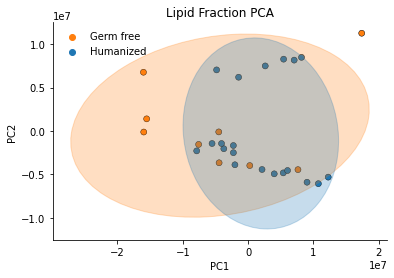

In [86]:
lipid_pca = PCA(n_components=3)
lipid_pca_res = lipid_pca.fit_transform(raw_lipid.drop(metabo_info_cols, 
                                                             axis=0, errors="ignore").reindex(metabo_metadata.index))
ax = sns.scatterplot(x=lipid_pca_res[:,0], y=lipid_pca_res[:,1],
                     hue=GF, hue_order=["Germ free", "Humanized"],
                     palette=["tab:orange","tab:blue"], edgecolor="black")
ax.set(xlabel="PC1", ylabel="PC2", title="Lipid Fraction PCA")
ax.spines[["top", "right"]].set_visible(False)

confidence_ellipse(lipid_pca_res[GF=="Germ free", 0], 
                   lipid_pca_res[GF=="Germ free", 1], 
                   n_std=2.0,
                   ax=ax, edgecolor='tab:orange',
                   alpha=0.25, facecolor='tab:orange')

confidence_ellipse(lipid_pca_res[GF=="Humanized", 0], 
                   lipid_pca_res[GF=="Humanized", 1], 
                   n_std=2.0,
                   ax=ax, edgecolor='tab:blue',
                   alpha=0.25, facecolor='tab:blue')


plt.legend(title=None, frameon=False)

### PCoA with Bray Curtis

In [87]:
aqueous_bray = beta_diversity(metric="braycurtis",
                              counts=raw_aqueous.drop(metabo_info_cols, errors="ignore", axis=0).reindex(metabo_metadata.index), 
                              ids=metabo_metadata.index)

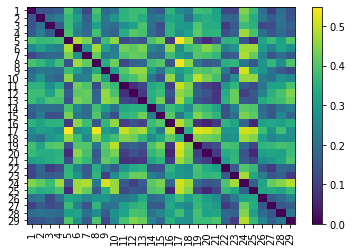

In [88]:
aqueous_bray

/Users/johnsterrett/mambaforge/envs/qiime2-2021.8/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.05496520077100246 and the largest is 0.8674034401331784.
  warn(


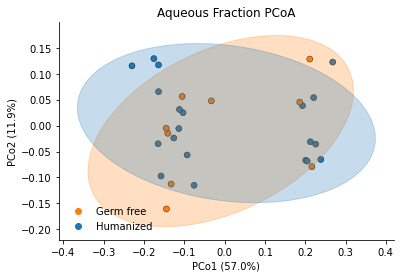

In [184]:
aqueous_pcoa_res = ordination.pcoa(aqueous_bray, number_of_dimensions=3)
prop_PC1 = round(aqueous_pcoa_res.proportion_explained[0]*100, 1)
prop_PC2 = round(aqueous_pcoa_res.proportion_explained[1]*100, 1)

ax = sns.scatterplot(x=aqueous_pcoa_res.samples["PC1"],
                     y=aqueous_pcoa_res.samples["PC2"],
                     hue=GF, hue_order=["Germ free", "Humanized"],
                     palette=["tab:orange","tab:blue"], edgecolor="black")
ax.set(xlabel=f"PCo1 ({prop_PC1}%)", ylabel=f"PCo2 ({prop_PC2}%)", title="Aqueous Fraction PCoA")
ax.spines[["top", "right"]].set_visible(False)

confidence_ellipse(aqueous_pcoa_res.samples.loc[GF=="Germ free", "PC1"], 
                   aqueous_pcoa_res.samples.loc[GF=="Germ free", "PC2"], 
                   n_std=2.0,
                   ax=ax, edgecolor='tab:orange',
                   alpha=0.25, facecolor='tab:orange')

confidence_ellipse(aqueous_pcoa_res.samples.loc[GF=="Humanized", "PC1"], 
                   aqueous_pcoa_res.samples.loc[GF=="Humanized", "PC2"], 
                   n_std=2.0,
                   ax=ax, edgecolor='tab:blue',
                   alpha=0.25, facecolor='tab:blue')


plt.legend(title=None, frameon=False)
plt.savefig("../figures/Aqueous_BC_PCoA_ellipse.pdf")

/Users/johnsterrett/mambaforge/envs/qiime2-2021.8/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.003990416001555215 and the largest is 0.22222600831230427.
  warn(


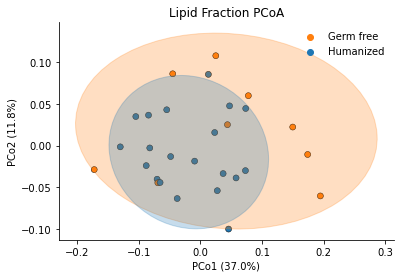

In [185]:
lipid_bray = beta_diversity(metric="braycurtis",
                              counts=raw_lipid.drop(metabo_info_cols, errors="ignore", axis=0).reindex(metabo_metadata.index), 
                              ids=metabo_metadata.index)

lipid_pcoa_res = ordination.pcoa(lipid_bray, number_of_dimensions=3)
prop_PC1 = round(lipid_pcoa_res.proportion_explained[0]*100, 1)
prop_PC2 = round(lipid_pcoa_res.proportion_explained[1]*100, 1)

ax = sns.scatterplot(x=lipid_pcoa_res.samples["PC1"],
                     y=lipid_pcoa_res.samples["PC2"],
                     hue=GF, hue_order=["Germ free", "Humanized"],
                     palette=["tab:orange","tab:blue"], edgecolor="black")
ax.set(xlabel=f"PCo1 ({prop_PC1}%)", ylabel=f"PCo2 ({prop_PC2}%)", title="Lipid Fraction PCoA")
ax.spines[["top", "right"]].set_visible(False)

confidence_ellipse(lipid_pcoa_res.samples.loc[GF=="Germ free", "PC1"], 
                   lipid_pcoa_res.samples.loc[GF=="Germ free", "PC2"], 
                   n_std=2.0,
                   ax=ax, edgecolor='tab:orange',
                   alpha=0.25, facecolor='tab:orange')

confidence_ellipse(lipid_pcoa_res.samples.loc[GF=="Humanized", "PC1"], 
                   lipid_pcoa_res.samples.loc[GF=="Humanized", "PC2"], 
                   n_std=2.0,
                   ax=ax, edgecolor='tab:blue',
                   alpha=0.25, facecolor='tab:blue')

plt.legend(title=None, frameon=False)
plt.savefig("../figures/Lipid_BC_PCoA_ellipse.pdf")

## Microbiome PCoA

In [91]:
microbiome_u_uni = Artifact.load("../microbiome/core-metrics/unweighted_unifrac_distance_matrix.qza").view(DistanceMatrix)

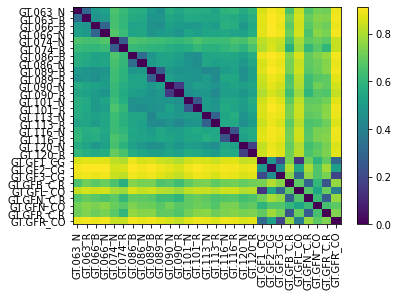

In [92]:
microbiome_u_uni

In [93]:
microbiome_u_uni_df = microbiome_u_uni.to_data_frame()

new_microbiome_u_uni_index = [int(microbiome_index_mapper[x]) for x in list(microbiome_u_uni_df.index)]
microbiome_u_uni_df.index = new_microbiome_u_uni_index
microbiome_u_uni_df = microbiome_u_uni_df.rename(index=microbiome_index_mapper, 
                                                 columns=microbiome_index_mapper)
microbiome_u_uni = DistanceMatrix(microbiome_u_uni_df, ids=microbiome_u_uni_df.index)

In [94]:
microbiome_pcoa_u_uni = ordination.pcoa(microbiome_u_uni, number_of_dimensions=3)

/Users/johnsterrett/mambaforge/envs/qiime2-2021.8/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.009383724064282497 and the largest is 2.3841342781282275.
  warn(


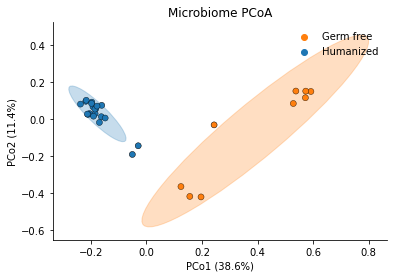

In [95]:
prop_PC1 = round(microbiome_pcoa_u_uni.proportion_explained[0], 3)*100
prop_PC2 = round(microbiome_pcoa_u_uni.proportion_explained[1], 3)*100

ax = sns.scatterplot(x=microbiome_pcoa_u_uni.samples["PC1"],
                     y=microbiome_pcoa_u_uni.samples["PC2"],
                     hue=GF, hue_order=["Germ free", "Humanized"],
                     palette=["tab:orange","tab:blue"], edgecolor="black")
ax.set(xlabel=f"PCo1 ({prop_PC1}%)", ylabel=f"PCo2 ({prop_PC2}%)", title="Microbiome PCoA")
ax.spines[["top", "right"]].set_visible(False)

confidence_ellipse(microbiome_pcoa_u_uni.samples.loc[GF=="Germ free", "PC1"], 
                   microbiome_pcoa_u_uni.samples.loc[GF=="Germ free", "PC2"], 
                   n_std=2.0,
                   ax=ax, edgecolor='tab:orange',
                   alpha=0.25, facecolor='tab:orange')

confidence_ellipse(microbiome_pcoa_u_uni.samples.loc[GF=="Humanized", "PC1"], 
                   microbiome_pcoa_u_uni.samples.loc[GF=="Humanized", "PC2"], 
                   n_std=2.0,
                   ax=ax, edgecolor='tab:blue',
                   alpha=0.25, facecolor='tab:blue')


plt.legend(title=None, frameon=False)
plt.savefig("../figures/U_Uni_PCoA_ellipse.pdf")


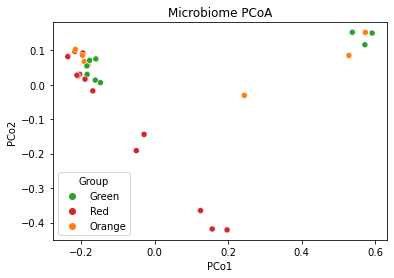

In [96]:
ax = sns.scatterplot(x="PC1",
                     y="PC2",
                     hue="Group",
                     palette=["tab:green", "tab:red", "tab:orange"],
                     data=pd.concat([microbiome_pcoa_u_uni.samples,
           metabo_metadata["Group"]], axis=1))
ax.set(xlabel="PCo1", ylabel="PCo2", title="Microbiome PCoA")
plt.legend(title="Group")
plt.show()

## Beta diversity differences

### Microbiome ~ GF

In [97]:
metadata["GF"] = metadata["PID"].apply(lambda x: "Germ free" if x=="Control" else "Humanized")

In [98]:
distance.permanova(microbiome_u_uni, 
                   grouping=metadata.reindex(microbiome_u_uni.ids)["PID"]=="Control",
                   permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                  2
test statistic            13.780608
p-value                      0.0001
number of permutations         9999
Name: PERMANOVA results, dtype: object

### Microbiome ~ Cohort

In [99]:
distance.permanova(microbiome_u_uni, 
                   grouping=metadata.reindex(microbiome_u_uni.ids)["Group"],
                   permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                  3
test statistic             1.841562
p-value                      0.0472
number of permutations         9999
Name: PERMANOVA results, dtype: object

#### Multiple PERMANOVA using Adonis

In [100]:
microbiome_file = "u_uni.csv"
output_dir = Path('Adonis')

output_dir.mkdir(parents=True, exist_ok=True)
full_u_uni_adonis_path = output_dir.joinpath(microbiome_file)
microbiome_u_uni.to_data_frame().to_csv(full_u_uni_adonis_path)

full_metadata_adonis_path = output_dir.joinpath("metadata.csv")
metadata.reindex(microbiome_u_uni.ids).to_csv(full_metadata_adonis_path)

subprocess.run(["Rscript", "multiple_permanova.R", 
                full_u_uni_adonis_path, full_metadata_adonis_path,
                "GF", "Group"])

subprocess.run(["Rscript", "multiple_permanova.R", 
                full_u_uni_adonis_path, full_metadata_adonis_path,
                "GF"])

This is vegan 2.6-4


[1] "Running Adonis for the following formula:"
dist.mat ~ GF
[1] "Permuting within the strata: Group"
Permutation test for adonis under reduced model
Terms added sequentially (first to last)
Blocks:  strata 
Permutation: free
Number of permutations: 99999

vegan::adonis2(formula = form, data = metadata, permutations = 99999, strata = metadata[, args$strata])
         Df SumOfSqs      R2      F Pr(>F)    
GF        1   2.0816 0.33792 13.781  1e-05 ***
Residual 27   4.0784 0.66208                  
Total    28   6.1600 1.00000                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


This is vegan 2.6-4


[1] "Running Adonis for the following formula:"
dist.mat ~ GF
[1] "Permuting within the strata: "
Permutation test for adonis under reduced model
Terms added sequentially (first to last)
Permutation: free
Number of permutations: 99999

vegan::adonis2(formula = form, data = metadata, permutations = 99999)
         Df SumOfSqs      R2      F Pr(>F)    
GF        1   2.0816 0.33792 13.781  1e-05 ***
Residual 27   4.0784 0.66208                  
Total    28   6.1600 1.00000                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


CompletedProcess(args=['Rscript', 'multiple_permanova.R', PosixPath('Adonis/u_uni.csv'), PosixPath('Adonis/metadata.csv'), 'GF'], returncode=0)

## Microbiome and metabolome composition corr with experiment

### Aqueous ~ GF

In [101]:
distance.permanova(aqueous_bray, 
                   grouping=metadata.reindex(aqueous_bray.ids)["PID"]=="Control")

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                  2
test statistic             0.150267
p-value                       0.947
number of permutations          999
Name: PERMANOVA results, dtype: object

In [102]:
distance.permanova(aqueous_bray, 
                   grouping=metadata.reindex(aqueous_bray.ids)["Group"])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                  3
test statistic             2.910418
p-value                       0.038
number of permutations          999
Name: PERMANOVA results, dtype: object

#### Multiple PERMANOVA using Adonis

In [103]:
aqueous_bray_file = "aqueous_bray.csv"
output_dir = Path('Adonis')

output_dir.mkdir(parents=True, exist_ok=True)
full_aqueous_bray_adonis_path = output_dir.joinpath(aqueous_bray_file)
aqueous_bray.to_data_frame().to_csv(full_aqueous_bray_adonis_path)

full_metadata_adonis_path = output_dir.joinpath("metadata.csv")
metadata.reindex(aqueous_bray.ids).to_csv(full_metadata_adonis_path)

subprocess.run(["Rscript", "multiple_permanova.R", 
                full_aqueous_bray_adonis_path, full_metadata_adonis_path,
                "GF", "Group"])

subprocess.run(["Rscript", "multiple_permanova.R", 
                full_aqueous_bray_adonis_path, full_metadata_adonis_path,
                "GF"])

This is vegan 2.6-4


[1] "Running Adonis for the following formula:"
dist.mat ~ GF
[1] "Permuting within the strata: Group"
Permutation test for adonis under reduced model
Terms added sequentially (first to last)
Blocks:  strata 
Permutation: free
Number of permutations: 99999

vegan::adonis2(formula = form, data = metadata, permutations = 99999, strata = metadata[, args$strata])
         Df SumOfSqs      R2      F Pr(>F)
GF        1  0.00746 0.00553 0.1503  0.938
Residual 27  1.34031 0.99447              
Total    28  1.34777 1.00000              


This is vegan 2.6-4


[1] "Running Adonis for the following formula:"
dist.mat ~ GF
[1] "Permuting within the strata: "
Permutation test for adonis under reduced model
Terms added sequentially (first to last)
Permutation: free
Number of permutations: 99999

vegan::adonis2(formula = form, data = metadata, permutations = 99999)
         Df SumOfSqs      R2      F Pr(>F)
GF        1  0.00746 0.00553 0.1503 0.9457
Residual 27  1.34031 0.99447              
Total    28  1.34777 1.00000              


CompletedProcess(args=['Rscript', 'multiple_permanova.R', PosixPath('Adonis/aqueous_bray.csv'), PosixPath('Adonis/metadata.csv'), 'GF'], returncode=0)

## Microbiome and metabolome composition corr with experiment

In [104]:
distance.permanova(lipid_bray, 
                   grouping=metadata.reindex(lipid_bray.ids)["PID"]=="Control",
                   permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                  2
test statistic             2.023805
p-value                      0.0623
number of permutations         9999
Name: PERMANOVA results, dtype: object

In [105]:
distance.permanova(lipid_bray, 
                   grouping=metadata.reindex(lipid_bray.ids)["Group"],
                   permutations=9999)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      29
number of groups                  3
test statistic             1.783071
p-value                      0.0497
number of permutations         9999
Name: PERMANOVA results, dtype: object

#### Multiple PERMANOVA using Adonis

In [106]:
lipid_bray_file = "lipid_bray.csv"
output_dir = Path('Adonis')

output_dir.mkdir(parents=True, exist_ok=True)
full_lipid_bray_adonis_path = output_dir.joinpath(lipid_bray_file)
lipid_bray.to_data_frame().to_csv(full_lipid_bray_adonis_path)

full_metadata_adonis_path = output_dir.joinpath("metadata.csv")
metadata.reindex(lipid_bray.ids).to_csv(full_metadata_adonis_path)

subprocess.run(["Rscript", "multiple_permanova.R", 
                full_lipid_bray_adonis_path, full_metadata_adonis_path,
                "GF", "Group"])

subprocess.run(["Rscript", "multiple_permanova.R", 
                full_lipid_bray_adonis_path, full_metadata_adonis_path,
                "GF"])

This is vegan 2.6-4


[1] "Running Adonis for the following formula:"
dist.mat ~ GF
[1] "Permuting within the strata: Group"
Permutation test for adonis under reduced model
Terms added sequentially (first to last)
Blocks:  strata 
Permutation: free
Number of permutations: 99999

vegan::adonis2(formula = form, data = metadata, permutations = 99999, strata = metadata[, args$strata])
         Df SumOfSqs      R2      F  Pr(>F)  
GF        1  0.04107 0.06973 2.0238 0.06703 .
Residual 27  0.54793 0.93027                 
Total    28  0.58900 1.00000                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


This is vegan 2.6-4


[1] "Running Adonis for the following formula:"
dist.mat ~ GF
[1] "Permuting within the strata: "
Permutation test for adonis under reduced model
Terms added sequentially (first to last)
Permutation: free
Number of permutations: 99999

vegan::adonis2(formula = form, data = metadata, permutations = 99999)
         Df SumOfSqs      R2      F  Pr(>F)  
GF        1  0.04107 0.06973 2.0238 0.05665 .
Residual 27  0.54793 0.93027                 
Total    28  0.58900 1.00000                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


CompletedProcess(args=['Rscript', 'multiple_permanova.R', PosixPath('Adonis/lipid_bray.csv'), PosixPath('Adonis/metadata.csv'), 'GF'], returncode=0)

## Microbiome and metabolome composition corr with experiment

In [107]:
pc_df = pd.concat([microbiome_pcoa_u_uni.samples,
                   pd.DataFrame(aqueous_pca_res, 
                                columns=["Aqueous PC1",
                                         "Aqueous PC2",
                                         "Aqueous PC3"],
                                index=metabo_metadata.index),
                   pd.DataFrame(lipid_pca_res, 
                                columns=["Lipid PC1",
                                         "Lipid PC2",
                                         "Lipid PC3"],
                                index=metabo_metadata.index),
                   metabo_metadata["Group"]
                  ],
                  axis=1)

pc_df.rename(columns={"PC1": "Microbiome PCo1",
                      "PC2": "Microbiome PCo2",
                      "PC3": "Microbiome PCo3"},
            inplace=True)

pc_exper_df = pd.DataFrame(index=pc_df.drop("Group", axis=1).columns,
                           columns=["F", "p", "significant", "-log10(p)"])

for pc in pc_exper_df.index:
    F,p = f_oneway(pc_df.loc[pc_df["Group"]=="Green", pc],
                   pc_df.loc[pc_df["Group"]=="Red", pc],
                   pc_df.loc[pc_df["Group"]=="Orange", pc])
    pc_exper_df.loc[pc, "F"] = F
    pc_exper_df.loc[pc, "p"] = p
    pc_exper_df.loc[pc, "significant"] = p < 0.05
    pc_exper_df.loc[pc, "-log10(p)"] = -np.log10(p)
    

In [108]:
pc_exper_df

,F,p,significant,-log10(p)
Microbiome PCo1,1.285994,0.293378,False,0.532572
Microbiome PCo2,5.05176,0.014012,True,1.853491
Microbiome PCo3,0.037189,0.963545,False,0.016128
Aqueous PC1,2.885225,0.07385,False,1.13165
Aqueous PC2,0.125921,0.882219,False,0.054424
Aqueous PC3,3.651526,0.040028,True,1.397639
Lipid PC1,1.559947,0.229185,False,0.639814
Lipid PC2,0.463251,0.634329,False,0.197686
Lipid PC3,0.003635,0.996372,False,0.001578


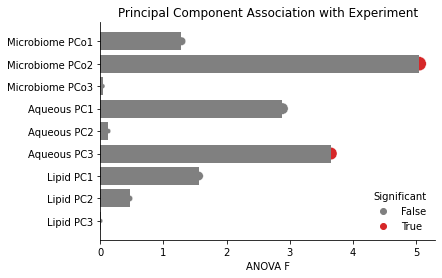

In [109]:
ax = sns.barplot(x="F", 
                 y="index",
                 palette=["grey"],
                 dodge=True,
                 data=pc_exper_df.reset_index())

sns.scatterplot(x="F", 
                y="index",
                hue="significant",
                size="-log10(p)", sizes=(20,200),
                palette=["tab:grey", "tab:red"],
                data=pc_exper_df.reset_index(),
                ax=ax)

handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[1:3],labels[1:3],
          frameon=False,
          title="Significant")

ax.spines[["top", "right"]].set_visible(False)
ax.set(xlabel="ANOVA F", ylabel=None,
       title="Principal Component Association with Experiment")


plt.show()

In [110]:
pco2_corr_df = pd.DataFrame(index=pc_df["Group"].unique(), 
                           columns=["r", "p", "significant","-log10(p)"])
for exp in pc_df["Group"].unique():
    r,p = pearsonr(pc_df["Group"]==exp,
                   pc_df["Microbiome PCo2"])

    pco2_corr_df.loc[exp, "r"] = r
    pco2_corr_df.loc[exp, "p"] = p
    pco2_corr_df.loc[exp, "significant"] = p < 0.05
    pco2_corr_df.loc[exp, "-log10(p)"] = -np.log10(p)

In [111]:
pco2_corr_df

,r,p,significant,-log10(p)
Green,0.320345,0.090226,False,1.04467
Red,-0.529007,0.003172,True,2.498668
Orange,0.268465,0.15909,False,0.798358


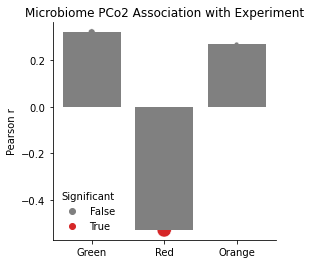

In [112]:
ax = sns.barplot(y="r", 
                 x="index",
                 palette=["grey"],
                 dodge=True,
                 data=pco2_corr_df.reset_index())

sns.scatterplot(y="r", 
                x="index",
                hue="significant",
                size="-log10(p)", sizes=(20,200),
                palette=["tab:grey", "tab:red"],
                data=pco2_corr_df.reset_index(),
                ax=ax)

handles,labels = ax.get_legend_handles_labels()
ax.legend(handles[1:3],labels[1:3],
          frameon=False,
          title="Significant")

ax.spines[["top", "right"]].set_visible(False)
ax.set(xlabel=None, ylabel="Pearson r",
       title="Microbiome PCo2 Association with Experiment")

plt.gcf().set_size_inches(4,4)
plt.show()

## Microbiome Diversity in GF

In [113]:
faith = Artifact.load("../microbiome/core-metrics/faith_pd_vector.qza").view(pd.Series)

faith.index = [int(microbiome_index_mapper[x]) for x in list(faith.index)]
faith = faith.sort_index()

In [114]:
faith_df = pd.concat([faith, metabo_metadata["PID"]=="Control"],
                     axis=1)
faith_df.columns = ["Faith's Phylogenetic Diversity",
                    "Germ Free"]

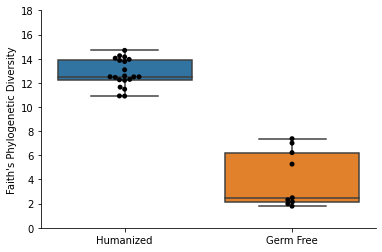

In [115]:
ax = sns.boxplot(x="Germ Free",
                 y="Faith's Phylogenetic Diversity",
                 palette=["tab:blue", "tab:orange"],
                 data=faith_df)

sns.swarmplot(x="Germ Free",
              y="Faith's Phylogenetic Diversity",
              palette=["black"],
              data=faith_df,
              ax=ax)

ax.set(xticklabels=["Humanized", "Germ Free"], xlabel=None,
       ylim=(0,18))

ax.spines[["top","right"]].set_visible(False)

plt.savefig("../figures/Faith_PD_GF_HU_boxplot.pdf")
plt.show()


In [116]:
ttest_ind(faith_df.loc[faith_df["Germ Free"]==True, "Faith's Phylogenetic Diversity"],
          faith_df.loc[faith_df["Germ Free"]==False, "Faith's Phylogenetic Diversity"],
          equal_var=False)

Ttest_indResult(statistic=-10.580124629524235, pvalue=1.2369763774204993e-06)

In [117]:
def welch_dof(x,y):
        dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
        print(f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")
        
welch_dof(faith_df.loc[faith_df["Germ Free"]==True, "Faith's Phylogenetic Diversity"],
          faith_df.loc[faith_df["Germ Free"]==False, "Faith's Phylogenetic Diversity"])

Welch-Satterthwaite Degrees of Freedom= 9.6814


In [118]:
mean_faith_GF = np.mean(faith_df.loc[faith_df["Germ Free"]==True, "Faith's Phylogenetic Diversity"])
mean_faith_HU = np.mean(faith_df.loc[faith_df["Germ Free"]==False, "Faith's Phylogenetic Diversity"])
print(f"GF mean faith PD = {mean_faith_GF}; HU mean faith PD = {mean_faith_HU}")

GF mean faith PD = 4.069413573209683; HU mean faith PD = 12.798685385247875


In [119]:
GF_faith = faith_df.loc[faith_df["Germ Free"]==True, "Faith's Phylogenetic Diversity"]
CI = t.interval(alpha=0.95, 
           df=len(GF_faith)-1, 
           loc=np.mean(GF_faith), 
           scale=sem(GF_faith)) 

print(f"GF Faith 95% CI = {CI}")

GF Faith 95% CI = (2.257422867364414, 5.881404279054952)


In [120]:
HU_faith = faith_df.loc[faith_df["Germ Free"]==False, "Faith's Phylogenetic Diversity"]
CI = t.interval(alpha=0.95, 
           df=len(HU_faith)-1, 
           loc=np.mean(HU_faith), 
           scale=sem(HU_faith)) 

print(f"HU Faith 95% CI = {CI}")

HU Faith 95% CI = (12.27211784166479, 13.325252928830961)


## What compounds are associated with microbiome composition?

In [121]:
raw_aqueous_samples = raw_aqueous.drop(metabo_info_cols, errors="ignore").sort_index()
raw_lipid_samples = raw_lipid.drop(metabo_info_cols, errors="ignore").sort_index()

In [122]:
def make_euclidean_distance_matrix(data, ids):
    data = np.array(data)
    
    matrix_shape = (data.shape[0], data.shape[0])
    out_matrix = np.empty(matrix_shape)
    
    for i, entry in enumerate(data):
        for j, entry_2 in enumerate(data):
            if i==j:
                out_matrix[i,i] = 0
            elif i<j:
                diff = np.abs(entry_2 - entry)
                out_matrix[i,j] = diff
                out_matrix[j,i] = diff
                
            else:
                pass
    
    return DistanceMatrix(out_matrix, ids=ids)

### Aqueous

In [123]:
raw_aqueous_samples_index = raw_aqueous_samples.index
raw_aqueous_mantel_results_u = pd.DataFrame(index=raw_aqueous_samples.columns,
                                            columns=["corr","p"])

for col in raw_aqueous_samples.columns:
    metabo_dist_mat = make_euclidean_distance_matrix(raw_aqueous_samples[col], 
                                                     ids=raw_aqueous_samples_index)
    
    corr, p, n = distance.mantel(metabo_dist_mat, microbiome_u_uni, method="pearson", permutations=10000)
    
    raw_aqueous_mantel_results_u.loc[col,"corr"] = corr
    raw_aqueous_mantel_results_u.loc[col,"p"] = p
    
#    print("\n================================")
#    print(f"Mantel on {col} and unweighted UniFrac:")
#    print(f"corr = {corr}, p = {p}")

In [124]:
raw_aqueous_mantel_results_u["Avg Abundance"] = raw_aqueous_samples.sum(axis=0)/raw_aqueous_samples.shape[0]
raw_aqueous_mantel_results_u["P<0.05"] = raw_aqueous_mantel_results_u["p"]<0.05
raw_aqueous_mantel_results_u["Log10 Avg Abundance"] = raw_aqueous_mantel_results_u["Avg Abundance"].apply(lambda x: np.log10(x+0.0001))

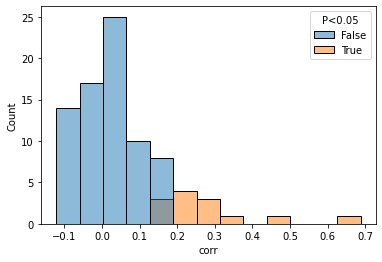

In [125]:
ax = sns.histplot(x = raw_aqueous_mantel_results_u["corr"], hue = raw_aqueous_mantel_results_u["P<0.05"])

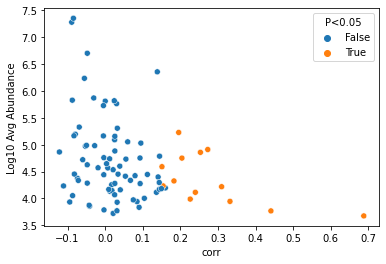

In [126]:
ax = sns.scatterplot(data=raw_aqueous_mantel_results_u,
                    x="corr",
                    y="Log10 Avg Abundance",
                    hue="P<0.05")

In [127]:
raw_aqueous_mantel_results_u[raw_aqueous_mantel_results_u["P<0.05"]].sort_values("corr", ascending=False)

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Compound,,,,,
Acetylagmatine_2.216,0.687763,0.0001,4731.414607,True,3.674991
Lactiflorin_7.997,0.44078,0.0006,5865.543005,True,3.768308
L-Pyridosine_6.949,0.331932,0.002,8817.897746,True,3.945365
Shikonofuran D_8.462,0.309641,0.0008,16539.438106,True,4.218521
gamma-Glutamyl-alanine_1.2,0.272857,0.0017,81400.845379,True,4.910629
Dopamine_2.414,0.253271,0.0019,72141.413232,True,4.858185
Menisporphine_1.669,0.239803,0.016998,13006.262416,True,4.114153
Ethyl-p-methoxycinnamate_8.596,0.226197,0.009899,9732.955728,True,3.988245
Rotundifoline_8.863,0.204089,0.029997,56364.943545,True,4.751009


In [128]:
raw_aqueous_mantel_results_u[raw_aqueous_mantel_results_u["P<0.05"]].sort_values("Avg Abundance")

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Compound,,,,,
Acetylagmatine_2.216,0.687763,0.0001,4731.414607,True,3.674991
Lactiflorin_7.997,0.44078,0.0006,5865.543005,True,3.768308
L-Pyridosine_6.949,0.331932,0.002,8817.897746,True,3.945365
Ethyl-p-methoxycinnamate_8.596,0.226197,0.009899,9732.955728,True,3.988245
Menisporphine_1.669,0.239803,0.016998,13006.262416,True,4.114153
Shikonofuran D_8.462,0.309641,0.0008,16539.438106,True,4.218521
Mandelonitrile_6.399,0.154139,0.030497,17136.260943,True,4.233916
4-GUANIDINOBUTANOATE**_1.4,0.182937,0.015398,21171.954963,True,4.325761
Enanderinanin G_9.541,0.151025,0.027497,39015.862426,True,4.591241


In [129]:
raw_aqueous_GF_ttest_results = pd.DataFrame(index=raw_aqueous_samples.columns,
                                            columns=["t","p"])

for col in raw_aqueous_samples.columns:

    t, p = ttest_ind(raw_aqueous_samples.loc[metabo_metadata["PID"]=="Control", col], 
                     raw_aqueous_samples.loc[metabo_metadata["PID"]!="Control", col])
    
    raw_aqueous_GF_ttest_results.loc[col, "t"] = t
    raw_aqueous_GF_ttest_results.loc[col,"p"] = p
    
raw_aqueous_GF_ttest_results["-Log10(p)"] = raw_aqueous_GF_ttest_results["p"].apply(lambda x: -np.log10(x))

for col in raw_aqueous_samples.columns:
    mean_GF = np.mean(raw_aqueous_samples.loc[metabo_metadata["PID"]=="Control", col])
    mean_humanized = np.mean(raw_aqueous_samples.loc[metabo_metadata["PID"]!="Control", col])
    
    raw_aqueous_GF_ttest_results.loc[col, "fold change"] = mean_humanized/mean_GF
    
raw_aqueous_GF_ttest_results["Log2(fold change)"] = raw_aqueous_GF_ttest_results["fold change"].apply(np.log2)
raw_aqueous_GF_ttest_results["P < 0.05"] = raw_aqueous_GF_ttest_results["p"].apply(lambda x: x<0.05)

In [130]:
raw_aqueous_GF_ttest_results

,t,p,-Log10(p),fold change,Log2(fold change),P < 0.05
Compound,,,,,,
1-AMINOCYCLOPROPANE-1-CARBOXYLATE**_1.039,1.760992,0.089563,1.047870,0.725731,-0.462493,False
"1-Fluorocyclohexadiene-cis,cis-1,2-diol_2.279",-0.869465,0.392257,0.406429,1.264459,0.338520,False
2-(1-Ethoxy-2-hydroxy)propyl-4-methoxyphenol_7.363,-0.607865,0.548356,0.260937,1.114103,0.155883,False
"2,5-Furandicarboxylic acid_1.474",2.193051,0.037097,1.430664,0.439034,-1.187595,True
"2,7-Dideacetyl-2,7-dibenzoyl-taxayunnanine F_9.347",-1.709302,0.098867,1.004950,3.678312,1.879044,False
...,...,...,...,...,...,...
Valganciclovir_8.169,-1.367749,0.182668,0.738337,1.662541,0.733390,False
Valyl-Hydroxyproline_1.651,-0.11741,0.907404,0.042199,1.065955,0.092147,False
Valyl-Tyrosine_6.482,0.249759,0.804664,0.094385,0.926172,-0.110648,False


[]

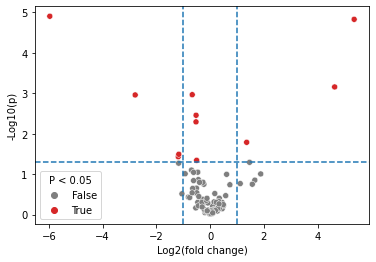

In [131]:
ax = sns.scatterplot(x="Log2(fold change)", y="-Log10(p)", 
                     hue="P < 0.05", palette=["tab:grey", "tab:red"],
                     data=raw_aqueous_GF_ttest_results)
ax.axhline(-np.log10(0.05), ls="--")
ax.axvline(np.log2(2), ls="--")
ax.axvline(-np.log2(2), ls="--")

ax.set()

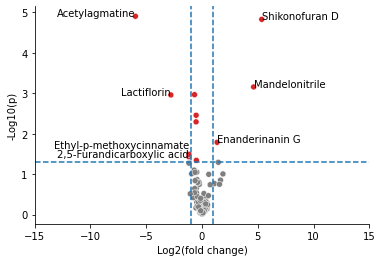

In [132]:
ax = sns.scatterplot(x="Log2(fold change)", y="-Log10(p)", 
                     hue="P < 0.05", palette=["tab:grey", "tab:red"],
                     data=raw_aqueous_GF_ttest_results,
                     legend=False)

# add lines
ax.axhline(-np.log10(0.05), ls="--")
ax.axvline(np.log2(2), ls="--")
ax.axvline(-np.log2(2), ls="--")

# plot names
for ind in raw_aqueous_GF_ttest_results.loc[
    (raw_aqueous_GF_ttest_results["P < 0.05"]) &
    (raw_aqueous_GF_ttest_results["Log2(fold change)"].apply(np.abs)>1)].index:
    
    if raw_aqueous_GF_ttest_results.loc[ind, "Log2(fold change)"] > 0:
        ax.text(x=raw_aqueous_GF_ttest_results.loc[ind, "Log2(fold change)"],
                y=raw_aqueous_GF_ttest_results.loc[ind, "-Log10(p)"],
                s=ind.split("_")[0].split(" - ")[0])
    # this one was overlapping
    elif ind=="Ethyl-p-methoxycinnamate_8.596":
        ax.text(x=raw_aqueous_GF_ttest_results.loc[ind, "Log2(fold change)"],
                y=raw_aqueous_GF_ttest_results.loc[ind, "-Log10(p)"]+0.15,
                s=ind.split("_")[0].split(" - ")[0],
                ha="right")
    else:
        ax.text(x=raw_aqueous_GF_ttest_results.loc[ind, "Log2(fold change)"],
                y=raw_aqueous_GF_ttest_results.loc[ind, "-Log10(p)"],
                s=ind.split("_")[0].split(" - ")[0],
                ha="right") #adjust horizontal alignment


ax.set(xlim=(-15,15))
ax.spines[["top","right"]].set_visible(False)
plt.show()

In [133]:
raw_aqueous_mantel_results_u.loc[raw_aqueous_mantel_results_u["P<0.05"]]

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Compound,,,,,
4-GUANIDINOBUTANOATE**_1.4,0.182937,0.015398,21171.954963,True,4.325761
Acetylagmatine_2.216,0.687763,0.0001,4731.414607,True,3.674991
Crotonic acid_1.021,0.195557,0.009399,169003.625828,True,5.227896
Dopamine_2.414,0.253271,0.0019,72141.413232,True,4.858185
Enanderinanin G_9.541,0.151025,0.027497,39015.862426,True,4.591241
Ethyl-p-methoxycinnamate_8.596,0.226197,0.009899,9732.955728,True,3.988245
gamma-Glutamyl-alanine_1.2,0.272857,0.0017,81400.845379,True,4.910629
Lactiflorin_7.997,0.44078,0.0006,5865.543005,True,3.768308
L-Pyridosine_6.949,0.331932,0.002,8817.897746,True,3.945365


#### Volcano plot with mantel p + log fold change between groups

In [134]:
aqueous_comb_volcano_df = pd.concat([raw_aqueous_mantel_results_u[["p", "P<0.05"]],
                                      raw_aqueous_GF_ttest_results["Log2(fold change)"]],
                                   axis=1)
aqueous_comb_volcano_df["-Log10(p)"] = aqueous_comb_volcano_df["p"].apply(lambda x: -np.log10(x))


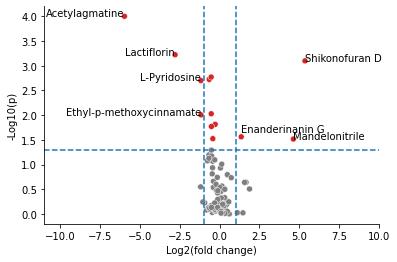

In [135]:
ax = sns.scatterplot(x="Log2(fold change)", y="-Log10(p)", 
                     hue="P<0.05", palette=["tab:grey", "tab:red"],
                     data=aqueous_comb_volcano_df,
                     legend=False)

# add lines
ax.axhline(-np.log10(0.05), ls="--")
ax.axvline(np.log2(2), ls="--")
ax.axvline(-np.log2(2), ls="--")

# plot names
for ind in aqueous_comb_volcano_df.loc[
    (aqueous_comb_volcano_df["P<0.05"]) &
    (aqueous_comb_volcano_df["Log2(fold change)"].apply(np.abs)>1)].index:
    
    if ind.startswith("C")==False:
        if aqueous_comb_volcano_df.loc[ind, "Log2(fold change)"] > 0:
            if ind=="Enanderinanin G_9.541":# this one was overlapping
                ax.text(x=aqueous_comb_volcano_df.loc[ind, "Log2(fold change)"],
                    y=aqueous_comb_volcano_df.loc[ind, "-Log10(p)"]+0.1,
                    s=ind.split("_")[0].split(" - ")[0])

            else:
                ax.text(x=aqueous_comb_volcano_df.loc[ind, "Log2(fold change)"],
                        y=aqueous_comb_volcano_df.loc[ind, "-Log10(p)"],
                        s=ind.split("_")[0].split(" - ")[0])

        else:
            ax.text(x=aqueous_comb_volcano_df.loc[ind, "Log2(fold change)"],
                    y=aqueous_comb_volcano_df.loc[ind, "-Log10(p)"],
                    s=ind.split("_")[0].split(" - ")[0],
                    ha="right") #adjust horizontal alignment


ax.set(xlim=(-11,10))
ax.spines[["top","right"]].set_visible(False)
plt.show()

In [136]:
gf_ttest_sig_aqueous = set(raw_aqueous_GF_ttest_results.loc[raw_aqueous_GF_ttest_results["P < 0.05"]].index)
mantel_sig_aqueous = set(raw_aqueous_mantel_results_u.loc[raw_aqueous_mantel_results_u["P<0.05"]].index)

These were found significantly associated with microbiome composition (per mantel) and associated with GF status (per ttest).

In [137]:
gf_ttest_sig_aqueous.intersection(mantel_sig_aqueous)

{'Acetylagmatine_2.216',
 'Crotonic acid_1.021',
 'Enanderinanin G_9.541',
 'Ethyl-p-methoxycinnamate_8.596',
 'Lactiflorin_7.997',
 'Mandelonitrile_6.399',
 'Shikonofuran D_8.462',
 'gamma-Glutamyl-alanine_1.2'}

### Lipid

In [138]:
raw_lipid_samples_index = raw_lipid_samples.index
raw_lipid_mantel_results_u = pd.DataFrame(index=raw_lipid_samples.columns,
                                            columns=["corr","p"])

for col in raw_lipid_samples.columns:
    metabo_dist_mat = make_euclidean_distance_matrix(raw_lipid_samples[col], 
                                                     ids=raw_lipid_samples_index)
    
    corr, p, n = distance.mantel(metabo_dist_mat, microbiome_u_uni, method="pearson", permutations=10000)
    
    raw_lipid_mantel_results_u.loc[col,"corr"] = corr
    raw_lipid_mantel_results_u.loc[col,"p"] = p

In [139]:
raw_lipid_mantel_results_u["Avg Abundance"] = raw_lipid_samples.sum(axis=0)/raw_lipid_samples.shape[0]
raw_lipid_mantel_results_u["P<0.05"] = raw_lipid_mantel_results_u["p"]<0.05
raw_lipid_mantel_results_u["Log10 Avg Abundance"] = raw_lipid_mantel_results_u["Avg Abundance"].apply(lambda x: np.log10(x+0.0001))

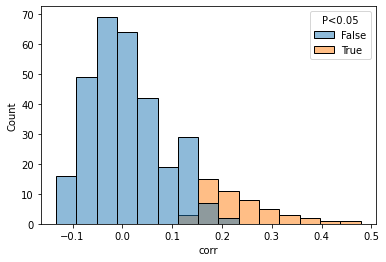

In [140]:
ax = sns.histplot(x = raw_lipid_mantel_results_u["corr"], hue = raw_lipid_mantel_results_u["P<0.05"])

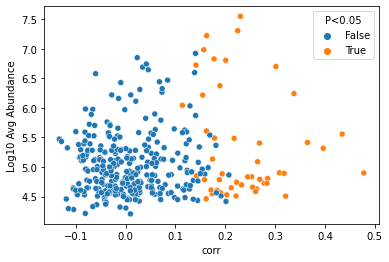

In [141]:
ax = sns.scatterplot(data=raw_lipid_mantel_results_u,
                    x="corr",
                    y="Log10 Avg Abundance",
                    hue="P<0.05")

In [142]:
raw_lipid_mantel_results_u[raw_lipid_mantel_results_u["P<0.05"]].sort_values("corr", ascending=False).head(30)

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance
Compound,,,,,
C458 - 3.513,0.478011,0.0003,79087.839483,True,4.898110
C846 - 4.744,0.434591,0.0018,360006.759793,True,5.556311
"CL(22:5(7Z,10Z,13Z,16Z,19Z)/18:2(9Z,12Z)/22:5(7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z))_4.399",0.396481,0.0009,206948.652966,True,5.315863
C1461 - 7.178,0.364886,0.0002,259461.314328,True,5.414073
C1509 - 6.495,0.337923,0.0005,1742868.905517,True,6.241265
C386 - 3.891,0.321089,0.0037,32037.518,True,4.505659
"MGDG(20:5(5Z,8Z,11Z,14Z,17Z)/18:4(6Z,9Z,12Z,15Z))_4.32",0.318217,0.0038,78046.566621,True,4.892354
C1085 - 4.761,0.30885,0.0032,79720.787276,True,4.901572
"PC(16:0/22:4(7Z,10Z,13Z,16Z))_5.523",0.3016,0.0005,5003955.337931,True,6.699313


One note from a quick google - Cerevisterol is a potent NF-kappa B inhibitor according to wikipedia

In [143]:
raw_lipid_GF_ttest_results = pd.DataFrame(index=raw_lipid_samples.columns,
                                            columns=["t","p"])

for col in raw_lipid_samples.columns:

    t, p = ttest_ind(raw_lipid_samples.loc[metabo_metadata["PID"]=="Control", col], 
                     raw_lipid_samples.loc[metabo_metadata["PID"]!="Control", col])
    
    raw_lipid_GF_ttest_results.loc[col, "t"] = t
    raw_lipid_GF_ttest_results.loc[col,"p"] = p
    
raw_lipid_GF_ttest_results["-Log10(p)"] = raw_lipid_GF_ttest_results["p"].apply(lambda x: -np.log10(x))

for col in raw_lipid_samples.columns:
    mean_GF = np.mean(raw_lipid_samples.loc[metabo_metadata["PID"]=="Control", col])
    mean_humanized = np.mean(raw_lipid_samples.loc[metabo_metadata["PID"]!="Control", col])
    
    raw_lipid_GF_ttest_results.loc[col, "fold change"] = mean_humanized/mean_GF
    
raw_lipid_GF_ttest_results["Log2(fold change)"] = raw_lipid_GF_ttest_results["fold change"].apply(np.log2)
raw_lipid_GF_ttest_results["P < 0.05"] = raw_lipid_GF_ttest_results["p"].apply(lambda x: x<0.05)

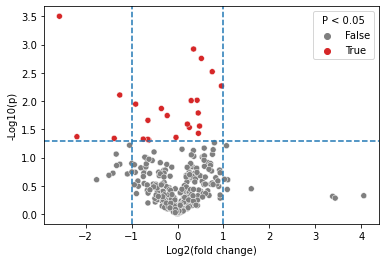

In [144]:
ax = sns.scatterplot(x="Log2(fold change)", y="-Log10(p)", 
                     hue="P < 0.05", palette=["tab:grey", "tab:red"],
                     data=raw_lipid_GF_ttest_results)
ax.axhline(-np.log10(0.05), ls="--")
ax.axvline(np.log2(2), ls="--")
ax.axvline(-np.log2(2), ls="--")

In [145]:
raw_lipid_GF_ttest_results.loc[raw_lipid_GF_ttest_results["P < 0.05"]]

,t,p,-Log10(p),fold change,Log2(fold change),P < 0.05
Compound,,,,,,
"2alpha,5alpha,10beta-Triacetoxy-14beta-propionyloxytaxa-4(20),11-diene_1.622",2.112278,0.044055,1.356007,0.977552,-0.032755,True
C1000 - 5.349,2.126242,0.042774,1.368818,0.219365,-2.188593,True
C1085 - 4.761,-2.562454,0.016288,1.788145,1.366593,0.450584,True
C1094 - 5.887,2.059741,0.049184,1.308180,0.649255,-0.623143,True
C1130 - 1.491,-2.783954,0.009689,2.013727,1.343720,0.426233,True
C1436 - 5.098,2.43092,0.021979,1.657995,0.640119,-0.643588,True
C1461 - 7.178,-3.257979,0.003025,2.519251,1.687915,0.755242,True
C1518 - 5.921,2.075137,0.047628,1.322135,0.639434,-0.645132,True
C1716 - 1.766,-2.326425,0.027746,1.556802,1.393966,0.479196,True


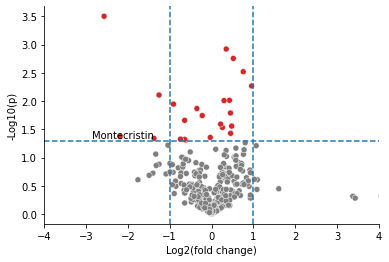

In [146]:
ax = sns.scatterplot(x="Log2(fold change)", y="-Log10(p)", 
                     hue="P < 0.05", palette=["tab:grey", "tab:red"],
                     data=raw_lipid_GF_ttest_results,
                     legend=False)

# add lines
ax.axhline(-np.log10(0.05), ls="--")
ax.axvline(np.log2(2), ls="--")
ax.axvline(-np.log2(2), ls="--")

# plot names
for ind in raw_lipid_GF_ttest_results.loc[
    (raw_lipid_GF_ttest_results["P < 0.05"]) &
    (raw_lipid_GF_ttest_results["Log2(fold change)"].apply(np.abs)>1)].index:
    
    
    if ind.startswith("C")==False:
        if raw_lipid_GF_ttest_results.loc[ind, "Log2(fold change)"] > 0:
            ax.text(x=raw_lipid_GF_ttest_results.loc[ind, "Log2(fold change)"],
                    y=raw_lipid_GF_ttest_results.loc[ind, "-Log10(p)"],
                    s=ind.split("_")[0].split(" - ")[0])
        # fix overlap (not needed since removing unannotated compounds but 
        # I'm going to keep it here in case I add the unannotated back in
        elif ind == "C846 - 4.744":
            ax.text(x=raw_lipid_GF_ttest_results.loc[ind, "Log2(fold change)"]-0.1,
                    y=raw_lipid_GF_ttest_results.loc[ind, "-Log10(p)"]+0.05,
                    s=ind.split("_")[0].split(" - ")[0],
                    ha="right")
        # fix overlap
        elif ind == "C1000 - 5.349":
            ax.text(x=raw_lipid_GF_ttest_results.loc[ind, "Log2(fold change)"]-0.1,
                    y=raw_lipid_GF_ttest_results.loc[ind, "-Log10(p)"]+0.1,
                    s=ind.split("_")[0].split(" - ")[0],
                    ha="right")
        # fix overlap
        elif ind == "PG(P-20:0/0:0)_3.626":
            ax.text(x=raw_lipid_GF_ttest_results.loc[ind, "Log2(fold change)"],
                    y=raw_lipid_GF_ttest_results.loc[ind, "-Log10(p)"]-0.05,
                    s=ind.split("_")[0].split(" - ")[0],
                    ha="right")
        else:
            ax.text(x=raw_lipid_GF_ttest_results.loc[ind, "Log2(fold change)"],
                    y=raw_lipid_GF_ttest_results.loc[ind, "-Log10(p)"],
                    s=ind.split("_")[0].split(" - ")[0],
                    ha="right") #adjust horizontal alignment


ax.set(xlim=(-4,4))
ax.spines[["top","right"]].set_visible(False)
plt.show()

In [147]:
lipid_comb_volcano_df = pd.concat([raw_lipid_mantel_results_u[["p", "P<0.05"]],
                                   raw_lipid_GF_ttest_results["Log2(fold change)"]],
                                   axis=1)
lipid_comb_volcano_df["-Log10(p)"] = lipid_comb_volcano_df["p"].apply(lambda x: -np.log10(x))


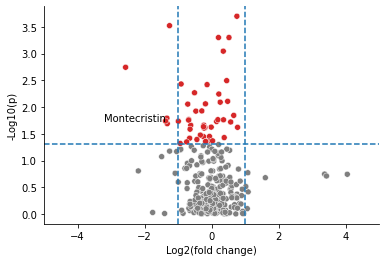

In [148]:
ax = sns.scatterplot(x="Log2(fold change)", y="-Log10(p)", 
                     hue="P<0.05", palette=["tab:grey", "tab:red"],
                     data=lipid_comb_volcano_df,
                     legend=False)

# add lines
ax.axhline(-np.log10(0.05), ls="--")
ax.axvline(np.log2(2), ls="--")
ax.axvline(-np.log2(2), ls="--")

# plot names
for ind in lipid_comb_volcano_df.loc[
    (lipid_comb_volcano_df["P<0.05"]) &
    (lipid_comb_volcano_df["Log2(fold change)"].apply(np.abs)>1)].index:
    
    if lipid_comb_volcano_df.loc[ind, "Log2(fold change)"] > 0:
        ax.text(x=lipid_comb_volcano_df.loc[ind, "Log2(fold change)"],
                y=lipid_comb_volcano_df.loc[ind, "-Log10(p)"],
                s=ind.split("_")[0].split(" - ")[0])

    else:
        if ind.startswith("C")==False:
            ax.text(x=lipid_comb_volcano_df.loc[ind, "Log2(fold change)"],
                    y=lipid_comb_volcano_df.loc[ind, "-Log10(p)"],
                    s=ind.split("_")[0].split(" - ")[0],
                    ha="right") #adjust horizontal alignment


ax.set(xlim=(-5,5))
ax.spines[["top","right"]].set_visible(False)
plt.show()

In [149]:
gf_ttest_sig_lipid = set(raw_lipid_GF_ttest_results.loc[raw_lipid_GF_ttest_results["P < 0.05"]].index)
mantel_sig_lipid = set(raw_lipid_mantel_results_u.loc[raw_lipid_mantel_results_u["P<0.05"]].index)

In [150]:
gf_ttest_sig_lipid.intersection(mantel_sig_lipid)

{'2alpha,5alpha,10beta-Triacetoxy-14beta-propionyloxytaxa-4(20),11-diene_1.622',
 'C1085 - 4.761',
 'C1094 - 5.887',
 'C1436 - 5.098',
 'C1461 - 7.178',
 'C1716 - 1.766',
 'C386 - 3.891',
 'C458 - 3.513',
 'C846 - 4.744',
 'CL(22:5(7Z,10Z,13Z,16Z,19Z)/18:2(9Z,12Z)/22:5(7Z,10Z,13Z,16Z,19Z)/20:4(5Z,8Z,11Z,14Z))_4.399',
 'MGDG(18:3(9Z,12Z,15Z)/18:3(9Z,12Z,15Z))_5.129',
 'Minwanensin_1.022',
 'Montecristin_4.032',
 'PC(16:0/22:4(7Z,10Z,13Z,16Z))_5.523',
 'PC(22:2(13Z,16Z)/14:1(9Z))_5.254',
 'PC(22:4(7Z,10Z,13Z,16Z)/16:0)_6.391'}

In [151]:
sig_ttest_mantel_comps = gf_ttest_sig_lipid.union(mantel_sig_lipid).union(gf_ttest_sig_aqueous).union(mantel_sig_aqueous)

with open("sig_ttest_mantel_compounds.ob", 'wb') as f:
    pickle.dump(sig_ttest_mantel_comps, f)

### Compounds detected

In [152]:
from statsmodels.stats.multitest import multipletests

In [153]:
res = multipletests(raw_aqueous_mantel_results_u["p"], method="fdr_bh")
raw_aqueous_mantel_results_u["BH reject"] = res[0]
raw_aqueous_mantel_results_u["BH p"] = res[1]

In [154]:
raw_aqueous_mantel_results_u[raw_aqueous_mantel_results_u["BH reject"]==True]

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance,BH reject,BH p
Compound,,,,,,,
Acetylagmatine_2.216,0.687763,0.0001,4731.414607,True,3.674991,True,0.008699
Dopamine_2.414,0.253271,0.0019,72141.413232,True,4.858185,True,0.028997
gamma-Glutamyl-alanine_1.2,0.272857,0.0017,81400.845379,True,4.910629,True,0.028997
Lactiflorin_7.997,0.44078,0.0006,5865.543005,True,3.768308,True,0.023198
L-Pyridosine_6.949,0.331932,0.002,8817.897746,True,3.945365,True,0.028997
Shikonofuran D_8.462,0.309641,0.0008,16539.438106,True,4.218521,True,0.023198


In [155]:
for comp in raw_aqueous_mantel_results_u[raw_aqueous_mantel_results_u["BH reject"]==True].index:
    print(comp)

Acetylagmatine_2.216
Dopamine_2.414
gamma-Glutamyl-alanine_1.2
Lactiflorin_7.997
L-Pyridosine_6.949
Shikonofuran D_8.462


In [156]:
res = multipletests(raw_lipid_mantel_results_u["p"], method="fdr_bh")
raw_lipid_mantel_results_u["BH reject"] = res[0]
raw_lipid_mantel_results_u["BH p"] = res[1]

In [157]:
raw_lipid_mantel_results_u[raw_lipid_mantel_results_u["BH reject"]==True]

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance,BH reject,BH p
Compound,,,,,,,
C1461 - 7.178,0.364886,0.0002,259461.314328,True,5.414073,True,0.043246
C1509 - 6.495,0.337923,0.0005,1742868.905517,True,6.241265,True,0.043246
C458 - 3.513,0.478011,0.0003,79087.839483,True,4.898110,True,0.043246
"PC(16:0/22:4(7Z,10Z,13Z,16Z))_5.523",0.3016,0.0005,5003955.337931,True,6.699313,True,0.043246


In [158]:
total_aqueous_compounds = raw_aqueous_samples.shape[1]
significant_aqueous_compounds = raw_aqueous_mantel_results_u["P<0.05"].sum()
corrected_sig_aq_c = raw_aqueous_mantel_results_u["BH reject"].sum()


print(f"{raw_aqueous_samples.shape[1]} green tea compounds were detected in the aqueous fraction of plasma")
print(f"{significant_aqueous_compounds} ({round(significant_aqueous_compounds/total_aqueous_compounds,3)*100}%)",
      "of these compounds were significantly associated with microbiome composition")
print(f"After applying a Benjamini-Hochberg correction, only ",
      f"{corrected_sig_aq_c} ({round(corrected_sig_aq_c/total_aqueous_compounds*100,1)}%) ",
      "were significantly associated with microbiome composition")


87 green tea compounds were detected in the aqueous fraction of plasma
13 (14.899999999999999%) of these compounds were significantly associated with microbiome composition
After applying a Benjamini-Hochberg correction, only  6 (6.9%)  were significantly associated with microbiome composition


In [159]:
total_lipid_compounds = raw_lipid_samples.shape[1]
significant_lipid_compounds = raw_lipid_mantel_results_u["P<0.05"].sum()
corrected_sig_lip_c = raw_lipid_mantel_results_u["BH reject"].sum()


print(f"{raw_lipid_samples.shape[1]} green tea compounds were detected in the aqueous fraction of plasma")
print(f"{significant_lipid_compounds} ({round(significant_lipid_compounds/total_lipid_compounds,3)*100}%)",
      "of these compounds were significantly associated with microbiome composition")
print(f"After applying a Benjamini-Hochberg correction, only ",
      f"{corrected_sig_lip_c} ({round(corrected_sig_lip_c/total_lipid_compounds*100,1)}%) ",
      "were significantly associated with microbiome composition")

346 green tea compounds were detected in the aqueous fraction of plasma
49 (14.2%) of these compounds were significantly associated with microbiome composition
After applying a Benjamini-Hochberg correction, only  4 (1.2%)  were significantly associated with microbiome composition


In [160]:
raw_lipid_mantel_results_u

,corr,p,Avg Abundance,P<0.05,Log10 Avg Abundance,BH reject,BH p
Compound,,,,,,,
?-Hederin_1.738,-0.053991,0.615638,42580.684207,False,4.629213,False,0.963426
16:3 Cholesteryl ester_7.312,-0.065971,0.387461,946450.328966,False,5.976098,False,0.866884
2-(1-Ethoxy-2-hydroxy)propyl-4-methoxyphenol-2-methyl-butyrate_1.111,-0.016816,0.860614,109460.475138,False,5.039257,False,0.990656
20-Deoxynarasin_4.939,0.123492,0.071793,87635.203517,False,4.942679,False,0.382159
22:3-Glc-Stigmasterol_7.436,0.045972,0.424858,296488.399414,False,5.472008,False,0.882624
...,...,...,...,...,...,...,...
TXB2-d4_1.835,0.149772,0.10079,76824.475814,False,4.885500,False,0.460988
Vernoflexin_0.988,-0.036923,0.777222,35053.051176,False,4.544726,False,0.990656
Violaxanthin_2.707,-0.005876,0.945005,53344.769207,False,4.727092,False,0.993617


In [161]:
def prep_sig_table(df, rounding_dict):
    
    df_copy = df.copy()

    # prep compound names
    names = df_copy.index
    names = list(map(lambda x: x.split(" - ")[0], names))
    names = list(map(lambda x: x.split("_")[0], names))
    df_copy.index = names

    for col, digits in rounding_dict.items():
        df_copy.loc[:,col] = df_copy.loc[:,col].apply(lambda x: round(x, digits))

    return df_copy

rounding_dict = {
    "t-test p": 3,
    "t-test BH p": 3,
    "t-test t": 1,
    "Mantel correlation": 2,
    "Mantel p": 3,
    "Mantel BH p": 3,
    "Log2(GF/HU)": 2,
    "Avg Abundance": 0
}


In [162]:
lipids_composition_results = raw_lipid_mantel_results_u.copy()

lipids_composition_results["t-test p"] = raw_lipid_GF_ttest_results["p"]
lipids_composition_results["t-test t"] = raw_lipid_GF_ttest_results["t"]

res = multipletests(lipids_composition_results["t-test p"], method="fdr_bh")
lipids_composition_results["t-test BH p"] = res[1]

lipids_composition_results["Log2(GF/HU)"] = raw_lipid_GF_ttest_results["Log2(fold change)"]


# lipids_composition_results.drop(["P<0.05","BH reject"], axis=1, inplace=True)

lipids_composition_results = lipids_composition_results.rename(columns={
                                           "corr": "Mantel correlation",
                                           "p": "Mantel p",
                                           "BH p": "Mantel BH p"}
                                                              )

lipids_composition_results = lipids_composition_results[
                           ["Mantel correlation", "Mantel p", "Mantel BH p",
                            "t-test t",           "t-test p", "t-test BH p",
                            "Log2(GF/HU)", "Avg Abundance"]]

sig_lipids_composition_results = lipids_composition_results.loc[
                                    ((lipids_composition_results["Mantel p"] < 0.05) |
                                    (lipids_composition_results["t-test p"] < 0.05)), :]

sig_lipids_composition_results = prep_sig_table(sig_lipids_composition_results, rounding_dict)
sig_lipids_composition_results.sort_values(by="Mantel p").to_csv("Sig_lipids_mantel_ttest_results_for_paper.csv")

lipids_composition_results.sort_values(by="Mantel p").to_csv("Lipids_mantel_ttest_results_for_paper.csv")

In [163]:
aqueous_composition_results = raw_aqueous_mantel_results_u.copy()

aqueous_composition_results["t-test p"] = raw_aqueous_GF_ttest_results["p"]
aqueous_composition_results["t-test t"] = raw_aqueous_GF_ttest_results["t"]

res = multipletests(aqueous_composition_results["t-test p"], method="fdr_bh")
aqueous_composition_results["t-test BH p"] = res[1]

aqueous_composition_results["Log2(GF/HU)"] = raw_aqueous_GF_ttest_results["Log2(fold change)"]


# lipids_composition_results.drop(["P<0.05","BH reject"], axis=1, inplace=True)

aqueous_composition_results = aqueous_composition_results.rename(columns={
                                           "corr": "Mantel correlation",
                                           "p": "Mantel p",
                                           "BH p": "Mantel BH p"}
                                                              )

aqueous_composition_results = aqueous_composition_results[
                           ["Mantel correlation", "Mantel p", "Mantel BH p",
                            "t-test t",           "t-test p", "t-test BH p",
                            "Log2(GF/HU)", "Avg Abundance"]]

aqueous_composition_results.sort_values(by="Mantel p").to_csv("Aqueous_mantel_ttest_results_for_paper.csv")
sig_aqueous_composition_results = aqueous_composition_results.loc[
                                    ((aqueous_composition_results["Mantel p"] < 0.05) |
                                    (aqueous_composition_results["t-test p"] < 0.05)), :]

sig_aqueous_composition_results = prep_sig_table(sig_aqueous_composition_results, rounding_dict)
sig_aqueous_composition_results.sort_values(by="Mantel p").to_csv("Sig_aqueous_mantel_ttest_results_for_paper.csv")

aqueous_composition_results.sort_values(by="Mantel p").to_csv("Aqueous_mantel_ttest_results_for_paper.csv")

In [164]:
aqueous_composition_results.sort_values(by="Mantel p")

,Mantel correlation,Mantel p,Mantel BH p,t-test t,t-test p,t-test BH p,Log2(GF/HU),Avg Abundance
Compound,,,,,,,,
Acetylagmatine_2.216,0.687763,0.0001,0.008699,5.330821,0.000013,0.00065,-5.967073,4731.414607
Lactiflorin_7.997,0.44078,0.0006,0.023198,3.65157,0.001104,0.019209,-2.790107,5865.543005
Shikonofuran D_8.462,0.309641,0.0008,0.023198,-5.265027,0.000015,0.00065,5.356644,16539.438106
gamma-Glutamyl-alanine_1.2,0.272857,0.0017,0.028997,3.047925,0.005107,0.063474,-0.527652,81400.845379
Dopamine_2.414,0.253271,0.0019,0.028997,1.239972,0.225655,0.654398,-0.650876,72141.413232
...,...,...,...,...,...,...,...,...
N2-Methylguanine_5.828,0.00374,0.949805,0.986481,-2.042142,0.051016,0.358684,1.465508,44312.274866
Valyl-Hydroxyproline_1.651,-0.004731,0.961104,0.986481,-0.11741,0.907404,0.958651,0.092147,145690.834077
Bruceine H_7.226,-0.003534,0.963804,0.986481,-0.514942,0.610784,0.900647,0.088035,57407.869


## Compounds associated with microbiome diversity

In [165]:
aqueous_faith_results = pd.DataFrame(index=raw_aqueous_samples.columns,
                                    columns=["r","p"])

for col in raw_aqueous_samples.columns:

    r, p = pearsonr(raw_aqueous_samples[col], 
                    faith)
    
    aqueous_faith_results.loc[col, "r"] = r
    aqueous_faith_results.loc[col,"p"] = p
    
aqueous_faith_results["-Log10(p)"] = aqueous_faith_results["p"].apply(lambda x: -np.log10(x))

for col in raw_aqueous_samples.columns:
    mean_GF = np.mean(raw_aqueous_samples.loc[metabo_metadata["PID"]=="Control", col])
    mean_humanized = np.mean(raw_aqueous_samples.loc[metabo_metadata["PID"]!="Control", col])
    
    aqueous_faith_results.loc[col, "fold change"] = mean_humanized/mean_GF
    
aqueous_faith_results["Log2(fold change)"] = aqueous_faith_results["fold change"].apply(np.log2)
aqueous_faith_results["P < 0.05"] = aqueous_faith_results["p"].apply(lambda x: x<0.05)

res = multipletests(aqueous_faith_results["p"], method="fdr_bh")
aqueous_faith_results["BH p"] = res[1]

aqueous_faith_sig = aqueous_faith_results.loc[aqueous_faith_results["P < 0.05"], 
                                              ["r", "p", "BH p", "Log2(fold change)"]
                                              ].sort_values(by="p")

prep_sig_table(aqueous_faith_sig,
                {"r": 2,
                 "p": 3,
                 "BH p": 3,
                 "Log2(fold change)":2}
                ).to_csv("aqueous_faith_results.csv")

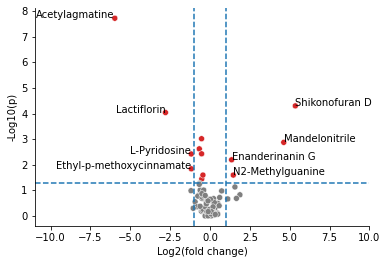

In [166]:
ax = sns.scatterplot(x="Log2(fold change)", y="-Log10(p)", 
                     hue="P < 0.05", palette=["tab:grey", "tab:red"],
                     data=aqueous_faith_results,
                     legend=False)

# add lines
ax.axhline(-np.log10(0.05), ls="--")
ax.axvline(np.log2(2), ls="--")
ax.axvline(-np.log2(2), ls="--")

# plot names
for ind in aqueous_faith_results.loc[
    (aqueous_faith_results["P < 0.05"]) &
    (aqueous_faith_results["Log2(fold change)"].apply(np.abs)>1)].index:
    
    if ind.startswith("C")==False: # Don't show unannotated compounds
        
        if aqueous_faith_results.loc[ind, "Log2(fold change)"] > 0:
            ax.text(x=aqueous_faith_results.loc[ind, "Log2(fold change)"],
                    y=aqueous_faith_results.loc[ind, "-Log10(p)"],
                    s=ind.split("_")[0].split(" - ")[0])
        else:
            ax.text(x=aqueous_faith_results.loc[ind, "Log2(fold change)"],
                    y=aqueous_faith_results.loc[ind, "-Log10(p)"],
                    s=ind.split("_")[0].split(" - ")[0],
                    ha="right") #adjust horizontal alignment


ax.set(xlim=(-11,10))
ax.spines[["top","right"]].set_visible(False)
plt.show()

In [167]:
lipid_faith_results = pd.DataFrame(index=raw_lipid_samples.columns,
                                    columns=["r","p"])

for col in raw_lipid_samples.columns:

    r, p = pearsonr(raw_lipid_samples[col], 
                    faith)
    
    lipid_faith_results.loc[col, "r"] = r
    lipid_faith_results.loc[col,"p"] = p
    
lipid_faith_results["-Log10(p)"] = lipid_faith_results["p"].apply(lambda x: -np.log10(x))

for col in raw_lipid_samples.columns:
    mean_GF = np.mean(raw_lipid_samples.loc[metabo_metadata["PID"]=="Control", col])
    mean_humanized = np.mean(raw_lipid_samples.loc[metabo_metadata["PID"]!="Control", col])
    
    lipid_faith_results.loc[col, "fold change"] = mean_humanized/mean_GF
    
lipid_faith_results["Log2(fold change)"] = lipid_faith_results["fold change"].apply(np.log2)
lipid_faith_results["P < 0.05"] = lipid_faith_results["p"].apply(lambda x: x<0.05)

res = multipletests(lipid_faith_results["p"], method="fdr_bh")
lipid_faith_results["BH p"] = res[1]

lipid_faith_sig = lipid_faith_results.loc[lipid_faith_results["P < 0.05"], 
                                          ["r", "p", "BH p", "Log2(fold change)"]
                                          ].sort_values(by="p")

prep_sig_table(lipid_faith_sig,
                {"r": 2,
                 "p": 3,
                 "BH p": 3,
                 "Log2(fold change)":2}
                ).to_csv("lipid_faith_results.csv")

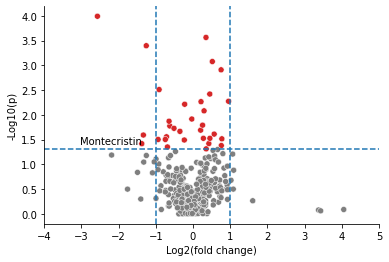

In [168]:
ax = sns.scatterplot(x="Log2(fold change)", y="-Log10(p)", 
                     hue="P < 0.05", palette=["tab:grey", "tab:red"],
                     data=lipid_faith_results,
                     legend=False)

# add lines
ax.axhline(-np.log10(0.05), ls="--")
ax.axvline(np.log2(2), ls="--")
ax.axvline(-np.log2(2), ls="--")

# plot names
for ind in lipid_faith_results.loc[
    (lipid_faith_results["P < 0.05"]) &
    (lipid_faith_results["Log2(fold change)"].apply(np.abs)>1)].index:
    
    if ind.startswith("C")==False:
        if lipid_faith_results.loc[ind, "Log2(fold change)"] > 0:
            ax.text(x=lipid_faith_results.loc[ind, "Log2(fold change)"],
                    y=lipid_faith_results.loc[ind, "-Log10(p)"],
                    s=ind.split("_")[0].split(" - ")[0])
        else:
            ax.text(x=lipid_faith_results.loc[ind, "Log2(fold change)"],
                    y=lipid_faith_results.loc[ind, "-Log10(p)"],
                    s=ind.split("_")[0].split(" - ")[0],
                    ha="right") #adjust horizontal alignment


ax.set(xlim=(-4,5))
ax.spines[["top","right"]].set_visible(False)
plt.show()

## Procrustes randomization test

In [169]:
#A procrustes randomization test! aka protest
def protest(a,b,n=999):
    """a: pd.DataFrame of Ordination coordinates for dataset a
     b: pd.DataFrame of Ordination coordinates for dataset b
     n: Integer, number of randomizations
     - - - - - - - - - - - - - - - - - - - - 
     returns:
     disparity, pval"""
    mtx1, mtx2, disparity = procrustes(a, b)
  
    #Randomization test time
    rows, cols = a.shape

    #disparities will be the list containing M^2 values for each test
    disparities = []
    for x in range(n):

      #start by randomly sampling 100% of the ordination coordinates
        a_rand = a.sample(frac=1,axis=0).reset_index(drop=True)
        b_rand = b.sample(frac=1,axis=0).reset_index(drop=True)

        #run the procrustes on the two randomly sampled coordinates
        mtx1_rand, mtx2_rand, disparity_rand = procrustes(a_rand,
                                                        b_rand)

        #add the result to disparities
        disparities.append(disparity_rand)

    #set pval = proportion of randomized samples where the random disparity is smaller than
    #our observed disparity
    pval = (sum([disparity > d for d in disparities])+1)/(n+1)

    return disparity, pval, disparities


In [170]:
def procrustes_plot(a,b, a_name,b_name, palette=None):
    mtx1, mtx2, disparity = procrustes(a, b)
    proplot = pd.concat([pd.DataFrame(mtx1), pd.DataFrame(mtx2)])
    proplot.columns = ["PCo1", "PCo2", "PCo3"]
    proplot["Dataset"] = [a_name]*a.shape[0] + [b_name]*b.shape[0]
    
    ax = sns.scatterplot(x="PCo1",y="PCo2",
                         style="Dataset",hue="Dataset",
                         data=proplot,
                         markers=["v","o"],
                         palette=palette,
                         s=150)

    for i in range(len(mtx1)):
        plt.plot([mtx1[i,0],mtx2[i,0]],
                 [mtx1[i,1],mtx2[i,1]],
                 c="black", linewidth=0.75)

In [171]:
microbiome_pcoa_u_uni = ordination.pcoa(microbiome_u_uni, number_of_dimensions=3)

/Users/johnsterrett/mambaforge/envs/qiime2-2021.8/lib/python3.8/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.009383724064282497 and the largest is 2.3841342781282275.
  warn(


#### Microbiome-aqueous

In [172]:
disparity, p, disparities = protest(microbiome_pcoa_u_uni.samples, aqueous_pcoa_res.samples)
print(f'pval: {p} \ndisparity: {disparity}')

pval: 0.933 
disparity: 0.9787676604221689


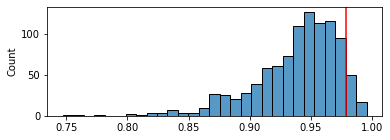

In [173]:
ax = sns.histplot(disparities)
ax.axvline(disparity, c="r")
plt.gcf().set_size_inches(6,2)

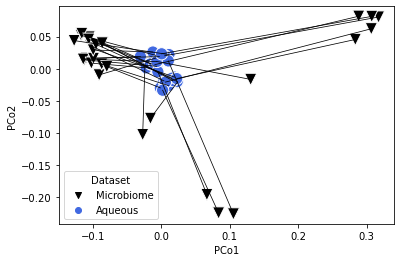

In [174]:
procrustes_plot(microbiome_pcoa_u_uni.samples, aqueous_pcoa_res.samples,
                "Microbiome", "Aqueous",
               palette=["black","royalblue"])

plt.savefig("../figures/PROTEST_Aqueous.pdf")
plt.show()

#### Microbiome-lipid

In [175]:
disparity, p, disparities = protest(microbiome_pcoa_u_uni.samples, lipid_pcoa_res.samples)
print(f'pval: {p} \ndisparity: {disparity}')

pval: 0.118 
disparity: 0.8856441507004892


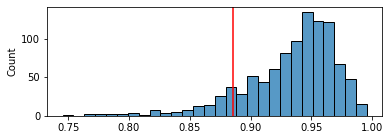

In [176]:
ax = sns.histplot(disparities)
ax.axvline(disparity, c="r")
plt.gcf().set_size_inches(6,2)
plt.show()

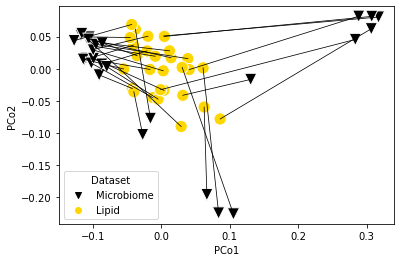

In [177]:
procrustes_plot(microbiome_pcoa_u_uni.samples, lipid_pcoa_res.samples,
                "Microbiome", "Lipid",
                palette=["black","gold"])

plt.savefig("../figures/PROTEST_Lipids.pdf")
plt.show()

#### Lipid-aqueous

In [178]:
disparity, p, disparities = protest(lipid_pcoa_res.samples, aqueous_pcoa_res.samples)
print(f'pval: {p} \ndisparity: {disparity}')

pval: 0.156 
disparity: 0.9059161766660341


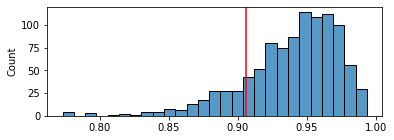

In [179]:
ax = sns.histplot(disparities)
ax.axvline(disparity, c="r")
plt.gcf().set_size_inches(6,2)
plt.show()

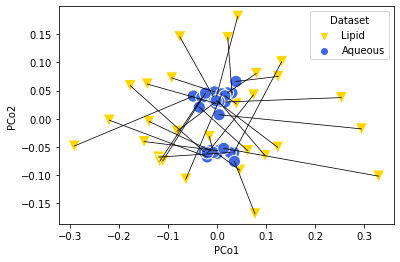

In [180]:
procrustes_plot(lipid_pcoa_res.samples, aqueous_pcoa_res.samples,
                "Lipid", "Aqueous",
               palette=["gold", "royalblue"])
plt.savefig("../figures/PROTEST_Aqueous_Lipid.pdf")
plt.show()

In [181]:
micro_pro, lipid_pro, disparity = procrustes(microbiome_pcoa_u_uni.samples, lipid_pcoa_res.samples)
proplot = pd.concat([pd.DataFrame(micro_pro), pd.DataFrame(lipid_pro)])
proplot.columns = ["PCo1", "PCo2", "PCo3"]
proplot["Dataset"] = ["Microbiome"]*microbiome.shape[0] + ["Lipid"]*raw_lipid_samples.shape[0]


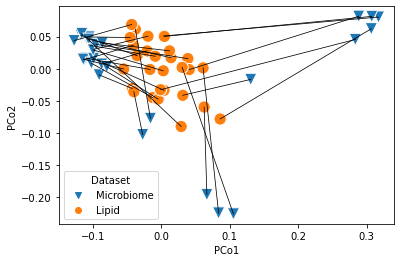

In [182]:
ax = sns.scatterplot(x="PCo1",y="PCo2",
                     style="Dataset",hue="Dataset",
                     data=proplot,
                     markers=["v","o"],
                     s=150)

for i in range(len(micro_pro)):
    plt.plot([micro_pro[i,0],lipid_pro[i,0]],
             [micro_pro[i,1],lipid_pro[i,1]],
             c="black", linewidth=0.75)

## Export data for Harry

In [119]:
microbiome.to_csv("../microbiome/rel_abundance_sotu_table.csv", index=True)
metabo_metadata.to_csv("../microbiome/micro_metabo_metadata.csv", index=True)

In [120]:
Artifact.load("../microbiome/tax_filtered_GT.qza").view(
    pd.DataFrame).rename(columns=tax, 
                         index=microbiome_index_mapper).sort_index().to_csv(
                                                                    "../microbiome/tax_filtered_GT.csv", 
                                                                    index=True)

In [121]:
Artifact.load("../microbiome/core-metrics/rarefied_table.qza").view(
    pd.DataFrame).rename(columns=tax, 
                         index=microbiome_index_mapper).sort_index().to_csv(
                                                                    "../microbiome/core-metrics/rarefied_table_tax.csv", 
                                                                    index=True)